# Equifinality Testing

Something that might add a lot of noise to coefficient estimation is equifinality in site-specific models. This Notebook analyzes the actual impact of such equifinality.

The basic procedure for a given watershed:

- Fit a calibrated model to the full timeseries. (We're interested in equally-performant coefficient sets, not in cal/val uncertainty, so we don't use a validation period.)
- Evaluate performance.
- Now, generate N random parameter sets, uniformly distributed. See which have less than an x% RMSE penalty and identify a behavioral envelope (think GLUE).
- Analyze distributions.

The immediate result, for $G$ gages and $p$ parameters, is a $(G\cdot N)\times p$ matrix of parameter sets mapped to a vector of $G\cdot N$ percentage RMSE penalties and a matrix of $G\times p$ original (fitted) parameter sets. This can be analyzed in a variety of ways; two major ones come to mind:

- Scatterplots showing whether the behavioral envelope varies with the value of the coefficient.
- Scatterplot of RMSE impact vs variable offset, showing how sensitive the variable is.
- Histograms of behavioral variability by site, identifying how variable the sensitivity is.

Another interesting question will be whether any parameter sets actually have a *negative* penalty, i.e., outperform the fitted coefficient set. (This is a distinct behavior from a, strictly speaking, calibrated model, since our site parameters aren't actually calibrated but rather explicitly computed from the data.)

For this test, we disable the anomaly GAM because setting it up for the randomized models would be logistically annoying.

# Setup

In [1]:
import NEWT
from rtseason import ThreeSine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os
import scipy
from scipy.stats.qmc import LatinHypercube
sns.set_context("paper")
bp = "/scratch/dphilippus/notebooks/next_validation/"

In [2]:
dev_data = pd.read_csv(bp + "DevDataBuffers.csv", dtype={"id": "str"}, parse_dates=["date"])[
    ["id", "date", "day", "temperature", "tmax"]
]
dev_data = dev_data.loc[(dev_data["temperature"] > -0.5) & (dev_data["temperature"] < 40)]

# Reference Performance

In [3]:
def perf_wcoef(site):
    model = NEWT.Watershed.from_data(site, use_anomgam=False)
    if model is None:
        return None
    pred = model.run_series(site)
    perf = NEWT.analysis.perf_summary(pred)["RMSE"]
    coefs = model.coefs_to_df().drop(columns=["R2", "RMSE"])
    print("|", end="")
    return pd.concat([coefs, perf], axis=1)

In [4]:
with warnings.catch_warnings(action="ignore"):
    reference = dev_data.groupby("id").apply(perf_wcoef, include_groups=False).droplevel(1)

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [5]:
reference

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,RMSE
id,,,,,,,,,,
01010000,8.227527,11.664508,323.0,27.5,120.0,236.0,1.989669,3.269881,0.313388,1.819758
01011000,8.547659,11.735706,322.0,27.0,120.0,204.0,2.563314,2.746746,0.271996,1.510067
01018035,9.074948,12.007753,321.0,28.0,120.0,206.0,1.838306,2.569034,0.364230,1.560736
01038000,10.871231,12.433309,319.0,27.0,169.0,200.0,0.899632,1.966065,0.380036,1.318067
010642505,8.232986,9.252760,321.0,26.0,122.0,233.0,1.766506,1.030557,0.333147,1.141534
...,...,...,...,...,...,...,...,...,...,...
385903107210800,7.163091,9.258731,300.0,87.0,143.0,201.0,2.083604,1.409694,0.375744,1.682636
394220106431500,6.965011,7.357272,324.0,84.0,156.0,237.0,2.823831,1.979052,0.257349,1.281264
402114105350101,4.352286,7.339022,301.0,88.0,153.0,237.0,2.495065,0.984321,0.329488,1.207342


# Randomized Parameters

We'll just generate one set of 10,000 for all sites, just to make things simple. Each parameter is allowed to be anywhere in the observed range (above).

Runtime was approx. 61 hours for 10,000 members x 921 sites (9,210,000 runs).

## Generate Samples

In [6]:
rawmat = pd.DataFrame(LatinHypercube(9).random(n=10000), columns=reference.columns[:9])

In [7]:
mins = reference[rawmat.columns].min()
maxes = reference[rawmat.columns].max()
ranges = maxes - mins
rpar = rawmat * ranges + mins

In [8]:
rpar

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef
0,3.354689,6.217179,320.628999,48.697249,150.676706,228.606455,4.221417,2.046528,0.371640
1,12.597154,6.185594,352.657273,56.728889,123.177662,208.687000,1.833207,0.944252,0.106699
2,24.996600,14.271297,335.534757,95.441058,127.388129,231.175366,-1.847489,3.706285,-0.085139
3,10.629460,7.026142,305.161287,83.861335,177.691230,214.134672,1.314795,2.866701,0.023681
4,6.758193,6.948623,321.368527,71.919840,151.428639,235.010540,4.350245,1.303470,0.273621
...,...,...,...,...,...,...,...,...,...
9995,27.603351,9.333994,351.810718,42.548028,163.959265,225.189439,1.864056,-0.152981,0.824908
9996,29.743748,7.253465,336.593827,9.345592,152.315708,210.467242,-2.171031,-1.340920,-0.084153
9997,9.002526,8.272347,363.956068,57.636847,148.575486,230.032977,1.265751,2.042766,0.291039
9998,25.833882,11.295668,340.588988,104.933301,164.175251,236.424031,2.989871,4.585740,0.258409


## Compute Performance

To avoid an excessively large result, for each site, we only keep the 1000 rows with the best performance. This will result in approx. 1M rows total, instead of the unmanageable 10M resulting from storing everything.

The first site, with 10k iterations, took about 200 seconds, or 0.02 seconds per run. That's fast individually, but too many to be manageable in a Jupyter notebook. This Notebook has been converted to Python and is running in the background.

In [9]:
def random_perf(params=rpar):
    def inner(site):
        daily = site.groupby(["day"], as_index=False)["tmax"].mean().rename(columns={"tmax": "mean_tmax"})
        pser = pd.Series([
            NEWT.analysis.perf_summary(
                NEWT.Watershed(
                    seasonality=ThreeSine(
                        Intercept=prow.Intercept,
                        Amplitude=prow.Amplitude,
                        SpringSummer=prow.SpringSummer,
                        FallWinter=prow.FallWinter,
                        SpringDay=prow.SpringDay,
                        SummerDay=prow.SummerDay,
                        FallDay=prow.FallDay,
                        WinterDay=prow.WinterDay
                    ),
                    at_coef=prow.at_coef,
                    at_day=daily
                ).run_series(site)
            )["RMSE"].iloc[0]
            for prow in params.itertuples()
        ]).rename("RMSE")
        print("|", end="")
        return pd.concat([params, pser], axis=1).sort_values("RMSE").head(1000)
    return inner

In [10]:
outfile = bp + "results/EquifinalMatrix.csv"
rerun = False
if os.path.exists(outfile) and not rerun:
    rpdata = pd.read_csv(outfile, dtype={"id": "str"}, index_col=[0, 1])
else:
    with warnings.catch_warnings(action="ignore"):
        start = time.time()
        rpdata = dev_data.loc[dev_data["id"].isin(reference.index)
                             ].groupby("id").apply(random_perf(), include_groups=False)
        print(f"Runtime: {(time.time() - start)/60: .02f} minutes for {len(rpar)} iterations over {len(reference)} sites")
        rpdata.to_csv(outfile)

## Analyze Performance

In [49]:
def behavioral(threshold, rpdata=rpdata, reference=reference):
    delta = (rpdata - reference)
    delta["RMSE"] = delta["RMSE"] / reference["RMSE"] * 100
    behav = delta.loc[delta["RMSE"] < threshold].melt("RMSE", ignore_index=False)
    reflong = reference.drop(columns=["RMSE"]).melt(ignore_index=False).rename(columns={"value": "ref_value"})
    res = reflong.merge(behav, on=["id", "variable"], how="left").assign(width=threshold)
    res.loc[res["value"].isna(), "value"] = 0
    # We also want to know how the offset relates to the total variability possible
    return res.reset_index().merge(
        pd.DataFrame(ranges).reset_index().rename(columns={"index": "variable", 0: "ref_range"}),
        on="variable"
    ).set_index("id")

behbins = pd.concat([behavioral(i) for i in [1, 2, 5, 10]])
behbins

,variable,ref_value,RMSE,value,width,ref_range
id,,,,,,
01010000,Intercept,8.227527,-27.223804,-2.644485,1,27.014903
01010000,Intercept,8.227527,-26.679329,-1.838703,1,27.014903
01010000,Intercept,8.227527,-26.558204,-2.430038,1,27.014903
01010000,Intercept,8.227527,-26.047503,-2.144891,1,27.014903
01010000,Intercept,8.227527,-25.007628,-2.037606,1,27.014903
...,...,...,...,...,...,...
385903107210800,at_coef,0.375744,9.431748,0.156654,10,1.005099
394220106431500,at_coef,0.257349,NaN,0.000000,10,1.005099
402114105350101,at_coef,0.329488,NaN,0.000000,10,1.005099


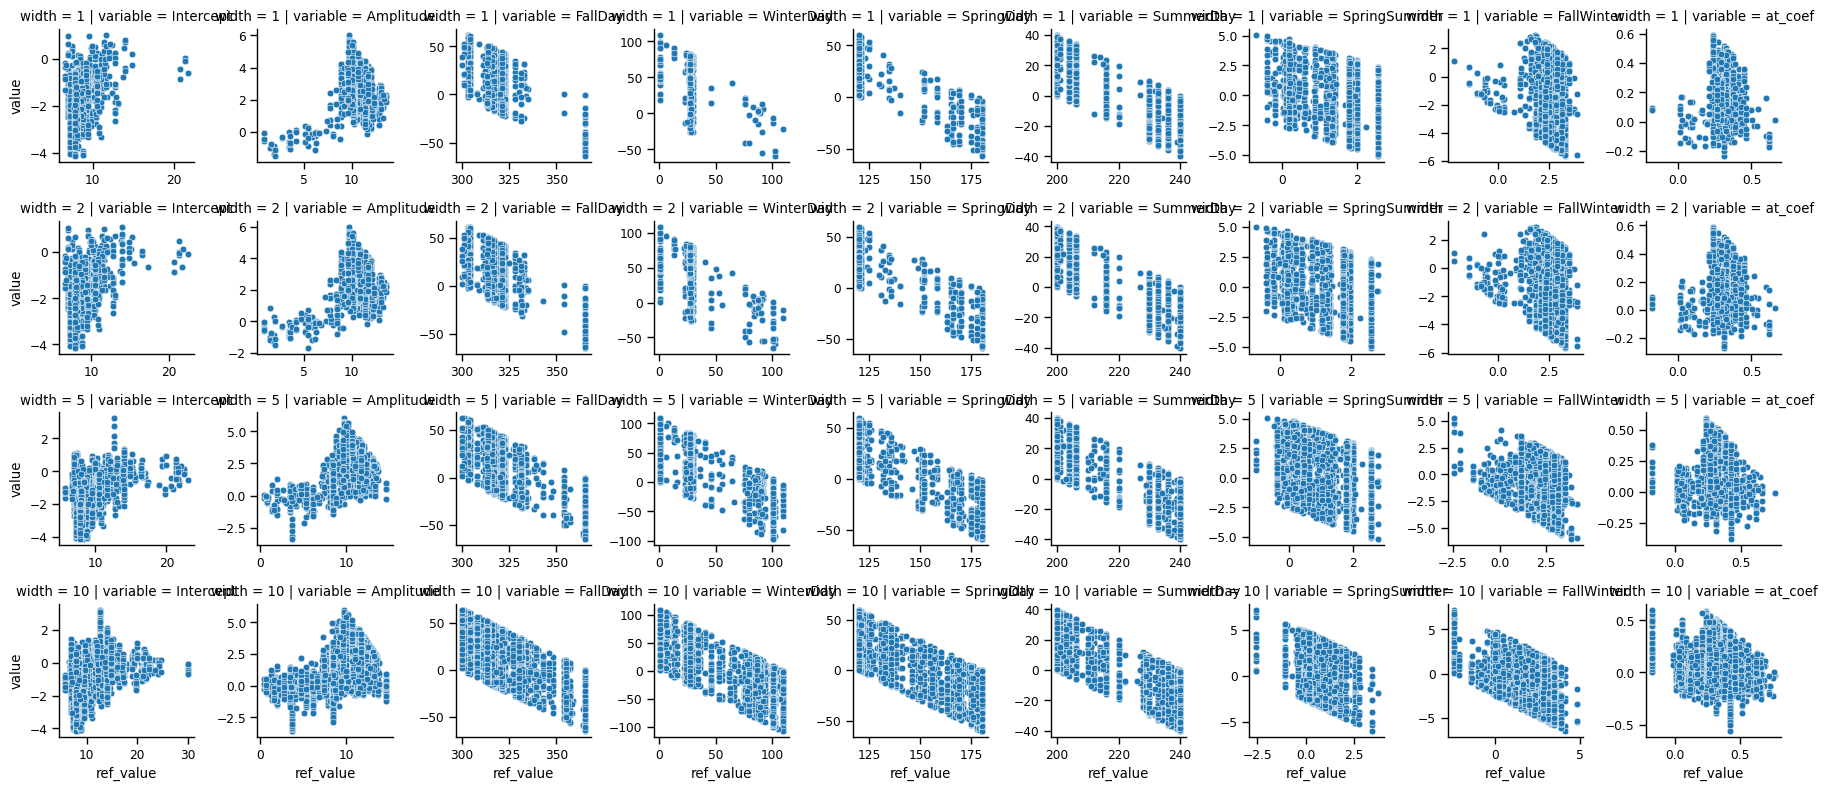

In [12]:
sns.relplot(behbins.loc[-behbins["RMSE"].isna()], x="ref_value", y="value", col="variable",
            row="width", height=2, facet_kws={"sharex": False, "sharey": False})

We know, of course, that the max RMSE-delta will be 10% from the filter above. Short of that threshold, we see some interesting effects:

- Reduced Intercept sometimes correlates to improved performance. Increased Intercept almost never does. This suggests a tendency to overestimate Intercept, presumably because sampling will be summer-biased. There are no behavioral parameter sets with an offset >3 or <-4 C.
- Amplitude is the exact opposite. Offsets of up to +5 C or so may produce improved performance.
- 

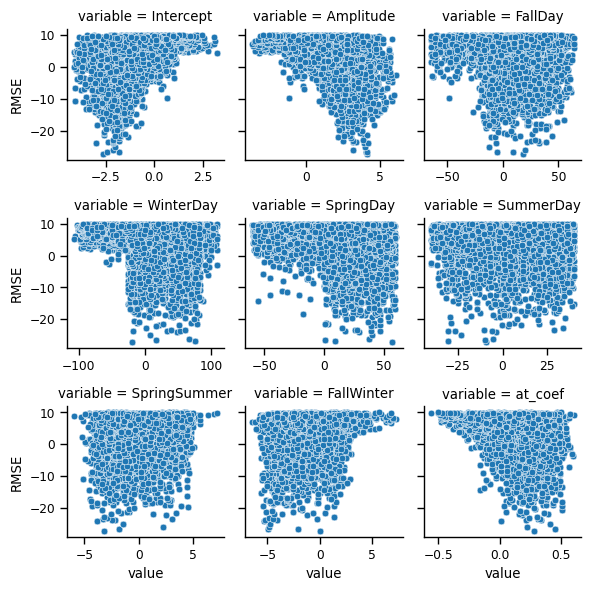

In [52]:
sns.relplot(behbins.loc[-behbins["RMSE"].isna()], x="value", y="RMSE", col="variable",
            col_wrap=3, height=2, facet_kws={"sharex": False})

Note that the large majority of sites don't have any behavioral combinations, at any threshold. However, of those that do, we see significant variation in the allowable range of variation. The dates are all low-sensitivity, with some of them even weighted towards larger offsets. Intercept and Amplitude are extremely sensitive, with no behavioral parameter sets above ~40% offset for Amplitude, and ~15% for Intercept. FallWinter, interestingly, is more sensitive than SpringSummer at low values, but has a higher allowable cutoff, up to 100%, whereas SpringSummer cuts off at about 70%. Air temperature sensitivity is quite sensitive.

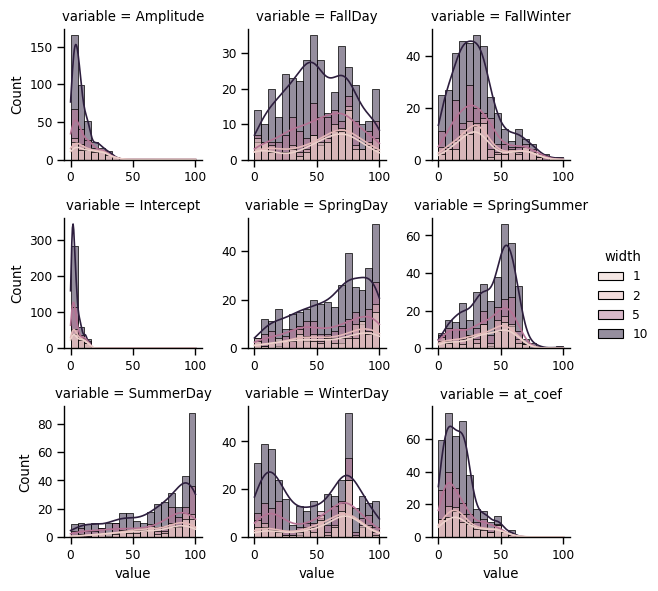

In [51]:
ewid = behbins.assign(value=lambda x: x["value"].abs()/x["ref_range"]*100).groupby(["id", "variable", "width"])["value"].max().reset_index()
sns.displot(ewid.loc[ewid["value"] > 0], x="value", col="variable", hue="width", col_wrap=3, height=2, kde=True, facet_kws={"sharex": False, "sharey": False})

In [31]:
nz = pd.DataFrame(ewid.assign(value=lambda x: x["value"] > 0).groupby(["variable", "width"])["value"].mean())
nzp = nz.reset_index().pivot(columns="width", index="variable")

In [33]:
nzp

value                              
width               1         2         5         10
variable                                            
Amplitude     0.085776  0.104235  0.185668  0.399566
FallDay       0.085776  0.104235  0.185668  0.399566
FallWinter    0.085776  0.104235  0.185668  0.399566
Intercept     0.085776  0.104235  0.185668  0.399566
SpringDay     0.085776  0.104235  0.185668  0.399566
SpringSummer  0.085776  0.104235  0.185668  0.399566
SummerDay     0.085776  0.104235  0.185668  0.399566
WinterDay     0.085776  0.104235  0.185668  0.399566
at_coef       0.085776  0.104235  0.185668  0.399566

<Axes: xlabel='None-width', ylabel='variable'>

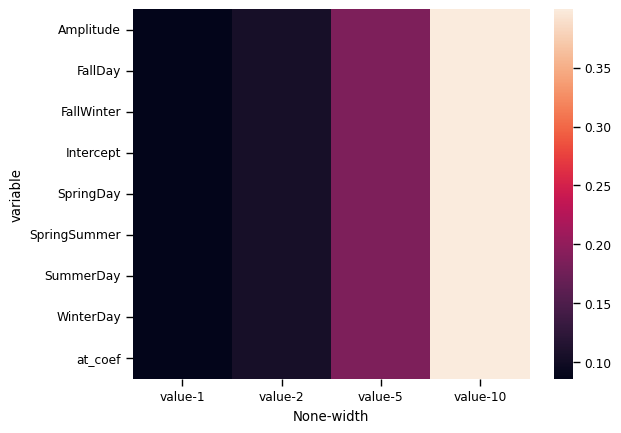

In [32]:
sns.heatmap(nzp)